Using GPU: NVIDIA GeForce RTX 4070 with CUDA version 12.4
Epoch [1/100], Batch [100/1076]
Epoch [1/100], Batch [200/1076]
Epoch [1/100], Batch [300/1076]
Epoch [1/100], Batch [400/1076]
Epoch [1/100], Batch [500/1076]
Epoch [1/100], Batch [600/1076]
Epoch [1/100], Batch [700/1076]
Epoch [1/100], Batch [800/1076]
Epoch [1/100], Batch [900/1076]
Epoch [1/100], Batch [1000/1076]
Epoch [1/100], Train Loss: 1.1791, Test Loss: 1.2006, Test Accuracy: 36.36%
Epoch [2/100], Batch [100/1076]
Epoch [2/100], Batch [200/1076]
Epoch [2/100], Batch [300/1076]
Epoch [2/100], Batch [400/1076]
Epoch [2/100], Batch [500/1076]
Epoch [2/100], Batch [600/1076]
Epoch [2/100], Batch [700/1076]
Epoch [2/100], Batch [800/1076]
Epoch [2/100], Batch [900/1076]
Epoch [2/100], Batch [1000/1076]
Epoch [2/100], Train Loss: 1.1315, Test Loss: 1.2293, Test Accuracy: 37.33%
Epoch [3/100], Batch [100/1076]
Epoch [3/100], Batch [200/1076]
Epoch [3/100], Batch [300/1076]
Epoch [3/100], Batch [400/1076]
Epoch [3/100], Batch

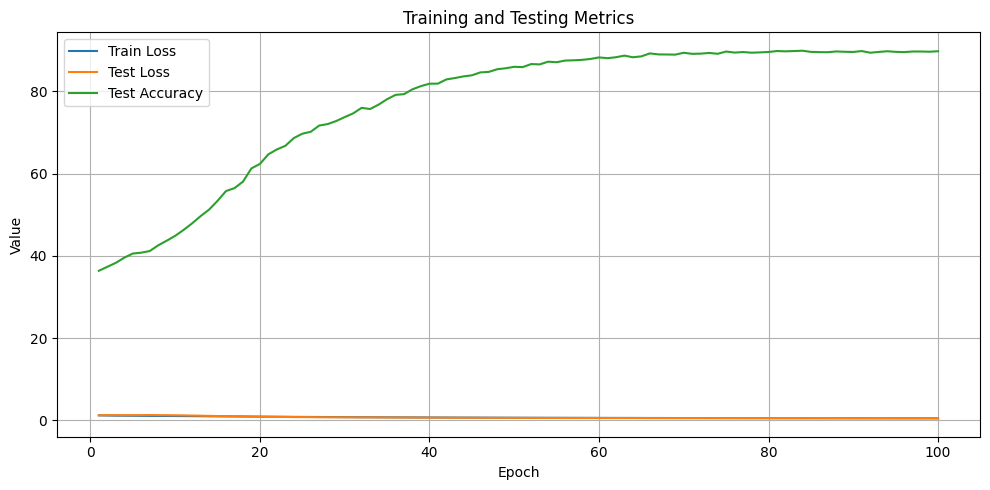

Real image "eyes_YCZKP8CF_Up.jpg" in class "Up" predicted as "Center".
Real image "eyes_5EK1C4F6_Down.jpg" in class "Down" predicted as "Down".
Real image "eyes_M7M9X1RM_Center.jpg" in class "Center" predicted as "Down".
Evaluation on real images complete.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import onnx
import onnxruntime as ort
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
from torch.amp import GradScaler, autocast  # Updated import
import random

# Define paths
base_dir = '/mnt/c/Users/rober/Desktop/GazeDetectionStudy'
dataset_dir = os.path.join(base_dir, 'dataset')  # Synthetic dataset
natural_dataset_dir = os.path.join(base_dir, 'natural_dataset')  # Real images
model_save_dir = os.path.join(base_dir, 'models', 'gazenet3')
os.makedirs(model_save_dir, exist_ok=True)

# Parameters
batch_size = 128
num_epochs = 100
learning_rate = 0.000001
num_classes = 3

# Data transforms for the synthetic dataset ('dataset')
synthetic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2)))),
    transforms.Lambda(lambda img: img.resize((random.randint(100, 224), random.randint(100, 224)), Image.BILINEAR).resize((224, 224), Image.BILINEAR)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization
                         std=[0.229, 0.224, 0.225])
])

# Data transforms for the natural dataset ('natural_dataset')
natural_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1)))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization
                         std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
# Synthetic dataset
synthetic_train_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=synthetic_transforms)
synthetic_test_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'test'), transform=synthetic_transforms)

# Natural dataset
natural_train_dataset = datasets.ImageFolder(os.path.join(natural_dataset_dir, 'train'), transform=natural_transforms)
natural_test_dataset = datasets.ImageFolder(os.path.join(natural_dataset_dir, 'test'), transform=natural_transforms)

# Augment the natural dataset by 100x
natural_train_dataset.samples = natural_train_dataset.samples * 100
natural_test_dataset.samples = natural_test_dataset.samples * 100

# Combine synthetic and natural datasets
train_dataset = ConcatDataset([synthetic_train_dataset, natural_train_dataset])
test_dataset = ConcatDataset([synthetic_test_dataset, natural_test_dataset])

# DataLoaders
num_workers = min(8, os.cpu_count())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

# Define the custom GazeNet3 model with enhanced regularization
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(0.2)  # Dropout layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(0.2)  # Dropout layer
        self.downsample = None
        if stride !=1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)

        out += identity
        out = self.relu(out)

        return out

class GazeNet3(nn.Module):
    def __init__(self, num_classes=3):
        super(GazeNet3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),  # Add dropout
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Instantiate the model
model = GazeNet3(num_classes=num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print CUDA device information
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)} with CUDA version {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU for training.")

# Enable CuDNN benchmarking for performance optimization
torch.backends.cudnn.benchmark = True

# Loss and optimizer with label smoothing and weight decay
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scaler = GradScaler()  # Updated GradScaler initialization

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type=device.type):  # Updated autocast context
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}]")

    train_losses.append(running_loss / len(train_loader))

    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type=device.type):  # Updated autocast context
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

# Save the model
pth_model_path = os.path.join(model_save_dir, 'gazenet3.pth')
torch.save(model.state_dict(), pth_model_path)
print(f'Model saved to {pth_model_path}')

# Export to ONNX
onnx_model_path = os.path.join(model_save_dir, 'gazenet3.onnx')
dummy_input = torch.randn(1, 3, 224, 224, device=device)
torch.onnx.export(
    model, dummy_input, onnx_model_path,
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=14
)
print(f'Model exported to ONNX format at {onnx_model_path}')

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

# Training Visualization
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Test Accuracy': test_accuracies
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss')
sns.lineplot(x='Epoch', y='Test Loss', data=df, label='Test Loss')
sns.lineplot(x='Epoch', y='Test Accuracy', data=df, label='Test Accuracy')
plt.title('Training and Testing Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate on real images from 'natural_dataset'
class_names = ['Up', 'Down', 'Center']
model.eval()

for cls in class_names:
    image_path = os.path.join(natural_dataset_dir, 'test', cls)
    if os.path.exists(image_path):
        image_files = os.listdir(image_path)
        if image_files:
            image_file = random.choice(image_files)
            full_image_path = os.path.join(image_path, image_file)
            image = Image.open(full_image_path).convert('RGB')
            image = natural_transforms(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(image)
                _, predicted = torch.max(output, 1)
                predicted_class = class_names[predicted.item()]

            print(f'Real image "{image_file}" in class "{cls}" predicted as "{predicted_class}".')

print("Evaluation on real images complete.")
